In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [2]:
plt.rcParams['figure.figsize'] = [10,5]

$\lambda[u] = \frac{c}{f[u]} \Rightarrow f[u] = \frac{c}{\lambda[u]}$

$l[u] = a \cdot l[mu]$ 

$t[u] = a/c \cdot t[mu]$

$f[u] = c/a \cdot f[mu]$

$a \lambda [mu]  = \frac{c}{f[mu]c/a} \Rightarrow a \lambda [mu]  = \frac{a}{f[mu]} \Rightarrow f[mu] = \frac{1}{\lambda[mu]}$

Stability relation:

$\frac{c \Delta t[u]}{\Delta x[u]}=S \Rightarrow$

$\frac{c \Delta t[mu] \cdot a/c}{\Delta x[mu] a}=S \Rightarrow \frac{\Delta t[mu] }{\Delta x[mu] }=S$

In [3]:
#Define conversion functions/factors to get to/from meep units and kms
#just need to specify c value
#meep to units
#Length factor to transform from meep units to kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


In [4]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 20

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

Pixel per unit:  20
Space resolution [meep]:  0.05
Time resolution [meep]:  0.025
Space resolution [um]:  0.049999999999999996
Time resolution [fs]:  0.08339102379953803


# Geometry Definition

In [5]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2)=(-8,8), y=(-sy/2,sy/2)=(-4,4)
sx = 90
sy = 7

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 1.0

#automatic positioning of boundaries
x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

# Distance Dependence

In [6]:
#Iteration on different parameters values
#Parameters: gap d, source frequency f, waveguides widths wvg_1_width, wvg_2_width
#waveguide refractive index

gaps_values = np.arange(0, 1.3, 0.1)
gaps_number = len(gaps_values)
#np.array([0, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12])

lengths = np.array([])

for index_d, d in enumerate(gaps_values):
    print("###############")
    print("## Beginning Iteration", index_d, "out of", gaps_number)
    print("#Waveguide gap:", d, "meep units")
    #Geometry and sources definition
    #each block has 3d widths, vector for center and material
    #permettivities are expressed as relatives. otherwise can use refractive index

    #waveguides widths
    wvg_1_width = 1
    wvg_2_width = wvg_1_width

    #waveguides center positions
    wvg_1_y = 0.5
    wvg_2_y = wvg_1_y - wvg_1_width/2 - d - wvg_2_width/2

    #waveguide material parameters
    index_bgnd = 3.85
    index_1 = 4.5
    index_2 = index_1

    #Source parameters: frequency and turn on time [meep]
    f_source = 0.15 
    t_source = 1
    
    #source position
    x_source = -sx/2 + pml_thickness + 0.3
    y_source = wvg_1_y

    src_width = wvg_1_width

    print("#Source frequency:", f_source*freq_unit*1e-12, "THz")
    print("#Source vacuum wavelength:", c/(f_source*freq_unit)*1e+6, "um")
    print("#Source background material wavelength:", (c/index_bgnd)/(f_source*freq_unit)*1e+6, "um")
    print("#Source waveguide wavelength:", (c/index_1)/(f_source*freq_unit)*1e+6, "um")

    #define geometry
    geometry = [mp.Block(mp.Vector3(mp.inf,mp.inf,mp.inf),
                         center=mp.Vector3(0, 0),
                         material=mp.Medium(index=index_bgnd)),
        
        
                mp.Block(mp.Vector3(mp.inf,wvg_1_width,mp.inf),
                         center=mp.Vector3(0, wvg_1_y),
                         material=mp.Medium(index=index_1)),

                mp.Block(mp.Vector3(mp.inf,wvg_2_width,mp.inf),
                         center=mp.Vector3(0, wvg_2_y),
                         material=mp.Medium(index=index_2))
               ]

    #define sources objects
    sources = [mp.Source(mp.ContinuousSource(frequency=f_source, width=t_source),
                         component=mp.Ez,
                         center=mp.Vector3(x_source,y_source),
                         size=mp.Vector3(0,src_width))]

    #define boundary conditions
    pml_layers = [mp.PML(pml_thickness)]


    #Instance simulation with chosen parameters
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        resolution=resolution)

    mp.verbosity(0)
    sim.run(until=500)

    #Get Ez profiles in waveguides
    ez_data_wvg_1 = sim.get_array(center=mp.Vector3(0,wvg_1_y), size=mp.Vector3(sx, 0.01), component=mp.Ez)
    print(ez_data_wvg_1.shape)

    ez_data_wvg_2 = sim.get_array(center=mp.Vector3(0,wvg_2_y), size=mp.Vector3(sx, 0.01), component=mp.Ez)
    print(ez_data_wvg_2.shape)

    x = np.arange(-sx/2, sx/2, 1/resolution)

    #envelopes calculation using Hilbert transform
    envelope_1 = np.abs(hilbert(ez_data_wvg_1[:,0]))
    envelope_2 = np.abs(hilbert(ez_data_wvg_2[:,0]))

    max_val = np.amax(envelope_1)
    max_index = np.argmax(envelope_1)

    threshold = 0.15

    #logical mask to get only values with e field under 15% of original value
    values_mask = (envelope_1<threshold*max_val) & (x>x_source) & (x<x_bound_up)
    try:  
        l_coupling = (x[values_mask])[0]-x_source
        print("#coupling length:", l_coupling, "Meep Units")
        print("#coupling length:", l_coupling*l_unit*1e+6, "um")
        lengths = np.append(lengths, l_coupling)
    except:
        print("#Problem while calculating the coupling length")
    
    print("## Iteration Ending")

###############
## Beginning Iteration 0 out of 13
#Waveguide gap: 0.0 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 8.349999999999454 Meep Units
#coupling length: 8.349999999999454 um
## Iteration Ending
###############
## Beginning Iteration 1 out of 13
#Waveguide gap: 0.1 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 8.59999999999944 Meep Units
#coupling length: 8.59999999999944 um
## Iteration Ending
###############
## Beginning Iteration 2 out of 13
#Waveguide gap: 0.2 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 10.049999999999358 Meep Units
#coupling length: 10.049999999999356 um
## Iteration Ending
###############
## Beginning Iteration 3 out of 13
#Waveguide gap: 0.30000000000000004 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 11.699999999999264 Meep Units
#coupling length: 11.699999999999262 um
## Iteration Ending
###############
## Beginning Iteration 4 out of 13
#Waveguide gap: 0.4 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 13.599999999999156 Meep Units
#coupling length: 13.599999999999154 um
## Iteration Ending
###############
## Beginning Iteration 5 out of 13
#Waveguide gap: 0.5 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 15.79999999999903 Meep Units
#coupling length: 15.799999999999029 um
## Iteration Ending
###############
## Beginning Iteration 6 out of 13
#Waveguide gap: 0.6000000000000001 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 18.44999999999888 Meep Units
#coupling length: 18.44999999999888 um
## Iteration Ending
###############
## Beginning Iteration 7 out of 13
#Waveguide gap: 0.7000000000000001 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 21.549999999998704 Meep Units
#coupling length: 21.549999999998704 um
## Iteration Ending
###############
## Beginning Iteration 8 out of 13
#Waveguide gap: 0.8 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 25.1499999999985 Meep Units
#coupling length: 25.149999999998496 um
## Iteration Ending
###############
## Beginning Iteration 9 out of 13
#Waveguide gap: 0.9 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 29.749999999998238 Meep Units
#coupling length: 29.749999999998238 um
## Iteration Ending
###############
## Beginning Iteration 10 out of 13
#Waveguide gap: 1.0 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 34.99999999999794 Meep Units
#coupling length: 34.99999999999794 um
## Iteration Ending
###############
## Beginning Iteration 11 out of 13
#Waveguide gap: 1.1 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 40.899999999997604 Meep Units
#coupling length: 40.8999999999976 um
## Iteration Ending
###############
## Beginning Iteration 12 out of 13
#Waveguide gap: 1.2000000000000002 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4814814814814814 um


FloatProgress(value=0.0, description='0% done ', max=500.0)

(1800, 2)
(1800, 2)
#coupling length: 47.9499999999972 Meep Units
#coupling length: 47.9499999999972 um
## Iteration Ending


Param 1: 7.289729713465962 1.5662868966427932
Param 2: 6.019088272033753 1.7011447645965445 1.7682185938021262
Param 3: 26.703290798081163 -0.07142251572967506 8.756593374950558


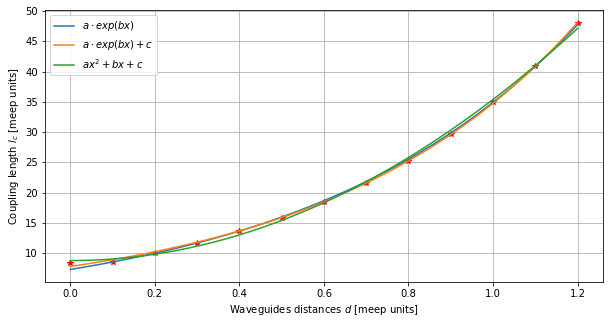

In [7]:
fig = plt.figure()

plt.plot(gaps_values, lengths, "r*")

plt.xlabel(r"Waveguides distances $d$ [meep units]")
plt.ylabel(r"Coupling length $l_c$ [meep units]")
plt.grid()

#maybe use waveguide 2's field to get coupling distance?

def func_1(x, a, b):
    return a*np.exp(b*x)

def func_2(x, a, b, c):
    return a*np.exp(b*x) + c

def func_3(x, a, b, c):
    return a*x**2 +b*x + c

popt_1, pcov_1 = curve_fit(func_1, gaps_values, lengths)
popt_2, pcov_2 = curve_fit(func_2, gaps_values, lengths)
popt_3, pcov_3 = curve_fit(func_3, gaps_values, lengths)

dummy_gaps = np.arange(np.amin(gaps_values), np.amax(gaps_values), 0.01)

plt.plot(dummy_gaps, func_1(dummy_gaps, *popt_1), label=r"$a \cdot exp(bx)$")
plt.plot(dummy_gaps, func_2(dummy_gaps, *popt_2), label=r"$a \cdot exp(bx)+c$")
plt.plot(dummy_gaps, func_3(dummy_gaps, *popt_3), label=r"$a x^2 +bx + c$")

plt.legend()

print("Param 1:",*popt_1)
print("Param 2:",*popt_2)
print("Param 3:",*popt_3)


# Width Dependence
Linearity breaks under 0.6 width

In [12]:
#Iteration on different parameters values
#Parameters: gap d, source frequency f, waveguides widths wvg_1_width, wvg_2_width
#waveguide refractive index

widths_values = np.arange(0.5, 1.4, 0.1)
widths_number = len(widths_values)
#np.array([0, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12])

lengths = np.array([])

d = 0.6

for index_w,w in enumerate(widths_values):
    print("###############")
    print("## Beginning Iteration ",index_w," out of ", widths_number)
    print("#Waveguide gap:", d, "meep units")
    print("#Waveguide width:", w, "meep units")
    #Geometry and sources definition
    #each block has 3d widths, vector for center and material
    #permettivities are expressed as relatives. otherwise can use refractive index

    #waveguides widths
    wvg_1_width = w
    wvg_2_width = wvg_1_width

    #waveguides center positions
    wvg_1_y = d/2+w/2
    wvg_2_y = wvg_1_y - wvg_1_width/2 - d - wvg_2_width/2

    #waveguide material parameters
    index_bgnd = 3.85
    index_1 = 4
    index_2 = index_1

    #print("#Waveguide refractive index: ", np.sqrt(eps))

    #Source parameters: frequency and turn on time [meep]
    f_source = 0.15 
    #exponential time to turn on source, to avoid steep jumps
    t_source = 1
    src_width = wvg_1_width

    #source position
    x_source = -sx/2 + pml_thickness + 0.3
    y_source = wvg_1_y

    print("#Source frequency:", f_source*freq_unit*1e-12, "THz")
    print("#Source vacuum wavelength:", c/(f_source*freq_unit)*1e+6, "um")
    print("#Source background material wavelength:", (c/index_bgnd)/(f_source*freq_unit)*1e+6, "um")
    print("#Source waveguide wavelength:", (c/index_1)/(f_source*freq_unit)*1e+6, "um")

    #define geometry
    geometry = [mp.Block(mp.Vector3(mp.inf,mp.inf,mp.inf),
                         center=mp.Vector3(0, 0),
                         material=mp.Medium(index=index_bgnd)),
        
        
                mp.Block(mp.Vector3(mp.inf,wvg_1_width,mp.inf),
                         center=mp.Vector3(0, wvg_1_y),
                         material=mp.Medium(index=index_1)),

                mp.Block(mp.Vector3(mp.inf,wvg_2_width,mp.inf),
                         center=mp.Vector3(0, wvg_2_y),
                         material=mp.Medium(index=index_2))
               ]

    #define sources objects
    sources = [mp.Source(mp.ContinuousSource(frequency=f_source, width=t_source),
                         component=mp.Ez,
                         center=mp.Vector3(x_source,y_source),
                         size=mp.Vector3(0,src_width))]

    #define boundary conditions
    pml_layers = [mp.PML(pml_thickness)]


    #Instance simulation with chosen parameters
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        resolution=resolution)

    mp.verbosity(0)
    sim.run(until=300)

    #Get Ez profiles in waveguides
    ez_data_wvg_1 = sim.get_array(center=mp.Vector3(0,wvg_1_y), size=mp.Vector3(sx, 0.01), component=mp.Ez)
    print(ez_data_wvg_1.shape)

    ez_data_wvg_2 = sim.get_array(center=mp.Vector3(0,wvg_2_y), size=mp.Vector3(sx, 0.01), component=mp.Ez)
    print(ez_data_wvg_2.shape)

    x = np.arange(-sx/2, sx/2, 1/resolution)

    #envelopes calculation using Hilbert transform
    envelope_1 = np.abs(hilbert(ez_data_wvg_1[:,0]))
    envelope_2 = np.abs(hilbert(ez_data_wvg_2[:,0]))

    max_val = np.amax(envelope_1)
    max_index = np.argmax(envelope_1)

    threshold = 0.15

    #logical mask to get only values with e field under 10% of original value
    values_mask = (envelope_1<threshold*max_val) & (x>x_source) & (x<x_bound_up)
    try:  
        l_coupling = (x[values_mask])[0]-x_source
        print("#coupling length:", l_coupling, "Meep Units")
        print("#coupling length:", l_coupling*l_unit*1e+6, "um")
        lengths = np.append(lengths, l_coupling)
    except:
        print("#Problem while calculating the coupling length")
    
    print("## Iteration Ending")
    print("###############")

###############
## Beginning Iteration
# Waveguide gap: 0.6 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6666666666666667 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 9.799999999999372 Meep Units
#coupling length: 9.79999999999937 um
## Iteration Ending
###############
###############
## Beginning Iteration
# Waveguide gap: 0.6 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6666666666666667 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 9.899999999999366 Meep Units
#coupling length: 9.899999999999366 um
## Iteration Ending
###############
###############
## Beginning Iteration
# Waveguide gap: 0.6 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6666666666666667 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 11.59999999999927 Meep Units
#coupling length: 11.59999999999927 um
## Iteration Ending
###############
###############
## Beginning Iteration
# Waveguide gap: 0.6 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6666666666666667 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 14.849999999999085 Meep Units
#coupling length: 14.849999999999083 um
## Iteration Ending
###############
###############
## Beginning Iteration
# Waveguide gap: 0.6 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6666666666666667 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 16.599999999998985 Meep Units
#coupling length: 16.599999999998985 um
## Iteration Ending
###############
###############
## Beginning Iteration
# Waveguide gap: 0.6 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6666666666666667 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 19.999999999998792 Meep Units
#coupling length: 19.999999999998792 um
## Iteration Ending
###############
###############
## Beginning Iteration
# Waveguide gap: 0.6 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6666666666666667 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 23.299999999998604 Meep Units
#coupling length: 23.299999999998604 um
## Iteration Ending
###############
###############
## Beginning Iteration
# Waveguide gap: 0.6 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6666666666666667 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 26.54999999999842 Meep Units
#coupling length: 26.54999999999842 um
## Iteration Ending
###############
###############
## Beginning Iteration
# Waveguide gap: 0.6 meep units
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6666666666666667 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 28.249999999998323 Meep Units
#coupling length: 28.249999999998323 um
## Iteration Ending
###############


Param 1: -4.9727777537556745 25.383333306640917


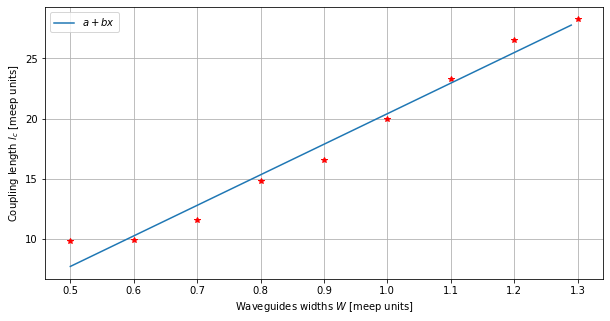

In [13]:
fig_width = plt.figure()

plt.plot(widths_values[:lengths.size], lengths, "r*")

plt.xlabel(r"Waveguides widths $W$ [meep units]")
plt.ylabel(r"Coupling length $l_c$ [meep units]")
plt.grid()

#maybe use waveguide 2's field to get coupling distance?

def func_1(x, a, b):
    return b*x + a


popt_1, pcov_1 = curve_fit(func_1, widths_values[:lengths.size], lengths)

dummy_gaps = np.arange(np.amin(widths_values), np.amax(widths_values), 0.01)

plt.plot(dummy_gaps, func_1(dummy_gaps, *popt_1), label=r"$a +bx$")


plt.legend()

print("Param 1:",*popt_1)

# Refractive index 

change the refractive index contrast 

###############
## Beginning Iteration 0 out of 13
#Waveguide refractive index: 3.9
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.7094017094017095 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 15.049999999999073 Meep Units
#coupling length: 15.049999999999073 um
## Iteration Ending
###############
## Beginning Iteration 1 out of 13
#Waveguide refractive index: 3.9499999999999997
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6877637130801688 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 18.499999999998877 Meep Units
#coupling length: 18.499999999998877 um
## Iteration Ending
###############
## Beginning Iteration 2 out of 13
#Waveguide refractive index: 3.9999999999999996
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6666666666666672 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 23.3999999999986 Meep Units
#coupling length: 23.399999999998595 um
## Iteration Ending
###############
## Beginning Iteration 3 out of 13
#Waveguide refractive index: 4.049999999999999
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6460905349794244 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 26.69999999999841 Meep Units
#coupling length: 26.699999999998408 um
## Iteration Ending
###############
## Beginning Iteration 4 out of 13
#Waveguide refractive index: 4.1
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6260162601626018 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 28.349999999998317 Meep Units
#coupling length: 28.349999999998317 um
## Iteration Ending
###############
## Beginning Iteration 5 out of 13
#Waveguide refractive index: 4.149999999999999
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.6064257028112456 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 29.69999999999824 Meep Units
#coupling length: 29.699999999998237 um
## Iteration Ending
###############
## Beginning Iteration 6 out of 13
#Waveguide refractive index: 4.199999999999999
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.5873015873015872 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 30.899999999998172 Meep Units
#coupling length: 30.89999999999817 um
## Iteration Ending
###############
## Beginning Iteration 7 out of 13
#Waveguide refractive index: 4.249999999999998
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.568627450980393 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 31.84999999999812 Meep Units
#coupling length: 31.84999999999812 um
## Iteration Ending
###############
## Beginning Iteration 8 out of 13
#Waveguide refractive index: 4.299999999999999
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.5503875968992251 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 32.64999999999807 Meep Units
#coupling length: 32.64999999999807 um
## Iteration Ending
###############
## Beginning Iteration 9 out of 13
#Waveguide refractive index: 4.349999999999998
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.53256704980843 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 34.04999999999799 Meep Units
#coupling length: 34.04999999999799 um
## Iteration Ending
###############
## Beginning Iteration 10 out of 13
#Waveguide refractive index: 4.399999999999999
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.5151515151515154 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 36.24999999999787 Meep Units
#coupling length: 36.24999999999787 um
## Iteration Ending
###############
## Beginning Iteration 11 out of 13
#Waveguide refractive index: 4.4499999999999975
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.4981273408239708 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 38.49999999999774 Meep Units
#coupling length: 38.49999999999774 um
## Iteration Ending
###############
## Beginning Iteration 12 out of 13
#Waveguide refractive index: 4.499999999999998
#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.481481481481482 um


FloatProgress(value=0.0, description='0% done ', max=300.0)

(1800, 2)
(1800, 2)
#coupling length: 40.79999999999761 Meep Units
#coupling length: 40.79999999999761 um
## Iteration Ending


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

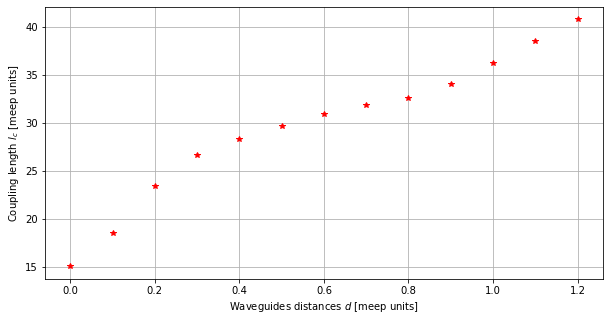

In [15]:
#Iteration on different parameters values
#Parameters: gap d, source frequency f, waveguides widths wvg_1_width, wvg_2_width
#waveguide refractive index

n_values = np.arange(3.9, 4.5, 0.05)
n_number = len(n_values)
#np.array([0, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12])

lengths = np.array([])

for index_n, n in enumerate(n_values):
    print("###############")
    print("## Beginning Iteration", index_n, "out of", n_number)
    print("#Waveguide refractive index:", n)
    #Geometry and sources definition
    #each block has 3d widths, vector for center and material
    #permettivities are expressed as relatives. otherwise can use refractive index

    #waveguides widths
    wvg_1_width = 1
    wvg_2_width = wvg_1_width

    d = 1.1

    #waveguides center positions
    wvg_1_y = 0.5
    wvg_2_y = wvg_1_y - wvg_1_width/2 - d - wvg_2_width/2

    #waveguide material parameters
    index_bgnd = 3.85
    index_1 = n
    index_2 = index_1

    #Source parameters: frequency and turn on time [meep]
    f_source = 0.15 
    t_source = 1
    
    #source position
    x_source = -sx/2 + pml_thickness + 0.3
    y_source = wvg_1_y

    src_width = wvg_1_width

    print("#Source frequency:", f_source*freq_unit*1e-12, "THz")
    print("#Source vacuum wavelength:", c/(f_source*freq_unit)*1e+6, "um")
    print("#Source background material wavelength:", (c/index_bgnd)/(f_source*freq_unit)*1e+6, "um")
    print("#Source waveguide wavelength:", (c/index_1)/(f_source*freq_unit)*1e+6, "um")

    #define geometry
    geometry = [mp.Block(mp.Vector3(mp.inf,mp.inf,mp.inf),
                         center=mp.Vector3(0, 0),
                         material=mp.Medium(index=index_bgnd)),
        
        
                mp.Block(mp.Vector3(mp.inf,wvg_1_width,mp.inf),
                         center=mp.Vector3(0, wvg_1_y),
                         material=mp.Medium(index=index_1)),

                mp.Block(mp.Vector3(mp.inf,wvg_2_width,mp.inf),
                         center=mp.Vector3(0, wvg_2_y),
                         material=mp.Medium(index=index_2))
               ]

    #define sources objects
    sources = [mp.Source(mp.ContinuousSource(frequency=f_source, width=t_source),
                         component=mp.Ez,
                         center=mp.Vector3(x_source,y_source),
                         size=mp.Vector3(0,src_width))]

    #define boundary conditions
    pml_layers = [mp.PML(pml_thickness)]


    #Instance simulation with chosen parameters
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        resolution=resolution)

    mp.verbosity(0)
    sim.run(until=300)

    #Get Ez profiles in waveguides
    ez_data_wvg_1 = sim.get_array(center=mp.Vector3(0,wvg_1_y), size=mp.Vector3(sx, 0.01), component=mp.Ez)
    print(ez_data_wvg_1.shape)

    ez_data_wvg_2 = sim.get_array(center=mp.Vector3(0,wvg_2_y), size=mp.Vector3(sx, 0.01), component=mp.Ez)
    print(ez_data_wvg_2.shape)

    x = np.arange(-sx/2, sx/2, 1/resolution)

    #envelopes calculation using Hilbert transform
    envelope_1 = np.abs(hilbert(ez_data_wvg_1[:,0]))
    envelope_2 = np.abs(hilbert(ez_data_wvg_2[:,0]))

    max_val = np.amax(envelope_1)
    max_index = np.argmax(envelope_1)

    threshold = 0.15

    #logical mask to get only values with e field under 15% of original value
    values_mask = (envelope_1<threshold*max_val) & (x>x_source) & (x<x_bound_up)
    try:  
        l_coupling = (x[values_mask])[0]-x_source
        print("#coupling length:", l_coupling, "Meep Units")
        print("#coupling length:", l_coupling*l_unit*1e+6, "um")
        lengths = np.append(lengths, l_coupling)
    except:
        print("#Problem while calculating the coupling length")
    
    print("## Iteration Ending")

No handles with labels found to put in legend.


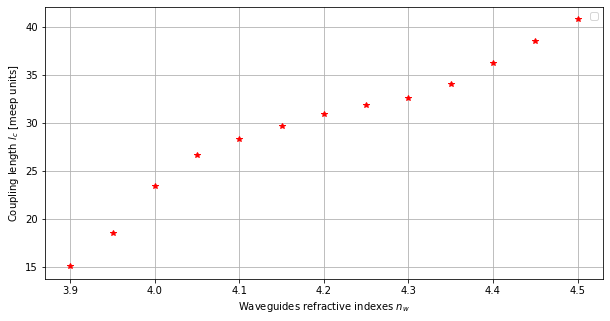

In [16]:
fig = plt.figure()

plt.plot(n_values, lengths, "r*")

plt.xlabel(r"Waveguides refractive indexes $n_w$")
plt.ylabel(r"Coupling length $l_c$ [meep units]")
plt.grid()

plt.legend()